In [1]:
# Decision trees, ensemble methods, clustering
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

%matplotlib inline
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import pydotplus

#loading data
train = pd.read_csv('train.csv')
train = train.dropna()
print(train.head())

    PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
6             7         0       1   
10           11         1       3   
11           12         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   

    Parch    Ticket     Fare Cabin Embarked  
1       0  PC 17599  71.2833   C85        C  
3       0    113803  53.1000  C123        S  
6       0     17463  51.8625   E46        S  
10      1   PP 9549  16.7000    G6        S  
11      0    113783  26.5500  C103        S  


In [2]:
#Feature engineering (need to make categorical features into numbers)
def word2letter(X_word):
    X_letter = []
    for x in X_word:
        X_letter.append(x[0])
    return X_letter

train['Cabin_letter'] = word2letter(train['Cabin'])
print(train.head())

    PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
6             7         0       1   
10           11         1       3   
11           12         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   

    Parch    Ticket     Fare Cabin Embarked Cabin_letter  
1       0  PC 17599  71.2833   C85        C            C  
3       0    113803  53.1000  C123        S            C  
6       0     17463  51.8625   E46        S            E  
10      1   PP 9549  16.7000    G6        S            G  
11      0    

In [9]:
def text2number(X_word, words):
    numbers = range(len(words))
    
    X_number = X_word.copy()
    for n, w in zip(numbers, words):
        X_number[X_word == w] = n
    return X_number

embarked_words = list(set(train['Embarked']))
train['Embarked_number'] = text2number(train['Embarked'], embarked_words)

sex_words = list(set(train['Sex']))
train['Sex_number'] = text2number(train['Sex'], sex_words)

cabin_words = list(set(train['Cabin_letter']))
train['Cabin_number'] = text2number(train['Cabin_letter'], cabin_words)

print(train.head())

    PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
6             7         0       1   
10           11         1       3   
11           12         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   

    Parch    Ticket     Fare Cabin Embarked Cabin_letter Embarked_number  \
1       0  PC 17599  71.2833   C85        C            C               0   
3       0    113803  53.1000  C123        S            C               1   
6       0     17463  51.8625   E46        S            E               1   
10  

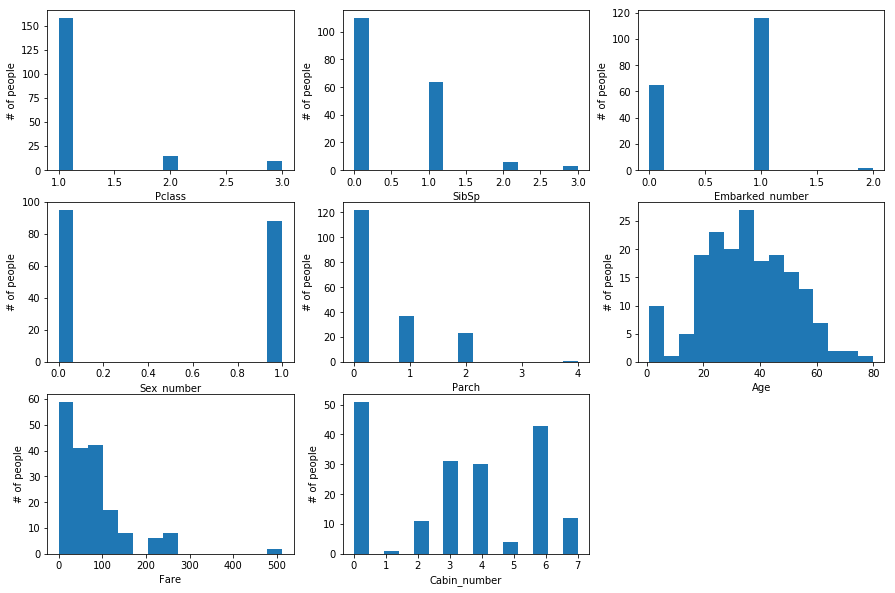

In [4]:
# plotting features
fig = plt.figure(figsize=(15,10))
for idx, f in enumerate(['Pclass', 'SibSp','Embarked_number','Sex_number', 'Parch','Age','Fare','Cabin_number']):
    ax = fig.add_subplot(3,3,idx+1)
    ax.hist(train[f],15)
    ax.set_xlabel(f)
    ax.set_ylabel('# of people')
plt.show()


In [10]:
##Making categorical features (coloumns of zeros (STAT 306))
X_num = train['Embarked_number']
nmax = max(X_num)+1

for num in range(nmax):
    X_cat = np.zeros_like(X_num)
    for idx, entry in enumerate(X_num):
        if entry == num:
            X_cat[idx] = 1
    name = 'Embarked_' + str(num)
    train[name] = X_cat

## Make categorical features for Cabin
X_num = train['Cabin_number']
nmax = max(X_num)+1

for num in range(nmax):
    X_cat = np.zeros_like(X_num)
    for idx, entry in enumerate(X_num):
        if entry == num:
            X_cat[idx] = 1
    name = 'Cabin_' + str(num)
    train[name] = X_cat

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_1,Embarked_2,Cabin_0,Cabin_1,Cabin_2,Cabin_3,Cabin_4,Cabin_5,Cabin_6,Cabin_7
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,1,0,0,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0,1,0,0,0,0,0,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,...,1,0,0,0,0,0,1,0,0,0
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,...,1,0,0,0,0,0,0,1,0,0
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,...,1,0,1,0,0,0,0,0,0,0


In [11]:
#Extracting features for model use
X = train[['Pclass', 'SibSp', 'Parch', 'Embarked_0', 'Embarked_1', 'Embarked_2','Sex_number', 'Age', 'Fare', 
           'Cabin_0', 'Cabin_1', 'Cabin_2', 'Cabin_3', 'Cabin_4', 'Cabin_5', 'Cabin_6', 'Cabin_7']].values
Y = train['Survived'].values        

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

M = X.shape[0]
M_train = int(M*0.8)

X_train = X[:M_train, :]
X_dev = X[M_train:, :]
Y_train = Y[:M_train]
Y_dev = Y[M_train:]


In [16]:
#Building the decision tree with python
dt = DecisionTreeClassifier(criterion="entropy", max_depth=10)
dt.fit(X_train, Y_train)
print('Accuracy :', dt.score(X_dev, Y_dev))
#dot_data = exports_graphviz(dt, out_file=None)
#graph = pydotplus.graph_from_dot_data(dot_data)


Accuracy : 0.756756756757


In [18]:
#Random forsets 
vec_acc = []
for num_est in [5,10,50,100,500,800,1000,1500]:
    rfc = RandomForestClassifier(criterion = "entropy", n_estimators = num_est)
    rfc.fit(X_train, Y_train)
    acc = rfc.score(X_dev,Y_dev)
    vec_acc.append(acc)
    print(acc)

    

0.702702702703
0.72972972973
0.72972972973
0.72972972973
0.756756756757
0.702702702703
0.702702702703
0.702702702703


In [29]:
#Ensemble methods, Important
k_vec = np.arange(1,21)
acc_vec = []
for k in k_vec:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    preds = knn.predict(X_dev)
    acc = np.mean(preds == Y_dev)
    acc_vec.append(acc)

best_k = k_vec[np.argmax(acc_vec)]
print(best_k)
print(max(acc_vec))

# the best model
knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(X_train, Y_train)
knn_preds = knn.predict(X_dev)

8
0.621621621622


In [30]:
# Ensemble method with Logisitic regression and L2-Regularization
c_vec = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
acc_vec = []
for c in c_vec:
    lr2 = LogisticRegression(penalty='l2', C=c)
    lr2.fit(X_train,Y_train)
    preds = lr2.predict(X_dev)
    acc = np.mean(preds == Y_dev)
    acc_vec.append(acc)

best_c = c_vec[np.argmax(acc_vec)]
print(best_c)
print(max(acc_vec))

lrtrue = LogisticRegression(penalty='l2', C=best_c)
lrtrue.fit(X_train,Y_train)
lrtrue_preds = lrtrue.predict(X_dev)

0.1
0.756756756757


In [32]:
#Take a vote for final ensemble maethod
final_preds = []
for k, l2 in zip(knn_preds, lrtrue_preds):
    print(k)
    print(l2)
    final_preds.append(np.round((k+l2)/2))
acc = np.mean(final_preds == Y_dev)
print(acc)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
0
0
1
1
1
1
1
1
1
1
0
1
1
1
0
0
0
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
0
1
1
1
1
1
1
0.72972972973
